# Best Implementation on Subtask A: Validation
Updated on August 20, 2021.

#### Project Information:
* Summer Project: Commonsense Validation and Explanation in Natural Language Processing<br>
* Objective Task: SemEval 2020 Task 4 - Commonsense Validation and Explanation (ComVE)<br>
* Supervisor: Dr Mark Lee<br>
* Student: Letian Li (2214560)
 
#### Task Description:
The subtask A is a validation task. The purpose is to determine which of two similar natural language statements is against common sense.

*Example:*  
> Task: Which of the two statements is against common sense?  
> Statement1: He put a turkey into the fridge.  
> Statement2: He put an elephant into the fridge. 

#### Solution:
This program will follow the steps:
1. General Preparation  
2. Data Processing 
3. Loading the Model and Optimizer  
4. Training 
5. Testing 


Please Note:  
1. In this implementation work, there is no validation process, because it has been carried out in the experiment work. Here, the validation dataset will be used as the training dataset to improve the performance of the best implementation.  
2. The optimal model and hyperparameters selected by the experiment require large storage (about 19G) on the GPU. If you just want to see how this implementation works, you can use a smaller model and batch size.

<!-- #### Task Description:
The subtask A is a validation task. The purpose is going to tell which of two similar natural language statements is against common sense.

*Example:* 
        
    Task: Which statement of the two is against common sense?
    Statement1: He put a turkey into the fridge.  
    Statement2: He put an elephant into the fridge.    -->

## 1. General Preparation

Import some common libraries.

In [1]:
from tqdm import tqdm
import time

Use GPU Facilities.

In [2]:
import torch
cuda_id = 2
device = torch.device("cuda:%s" % cuda_id if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(cuda_id) if torch.cuda.is_available() else "cpu"
print("We are using the device %s - %s" % (device, device_name))

We are using the device cuda:2 - TITAN RTX


Set the model and hyperparameters for implementation.

In [3]:
# Best implementation
model_name = "roberta-large"
optimizer_name = 'Adam'
learning_rate = 1e-5
batch_size = 128
epoch = 15

# # Minor implementation
# model_name = "distilbert-base-uncased"
# optimizer_name = 'Adam'
# learning_rate = 1e-5
# batch_size = 8
# epoch = 5

Set the path to save the trained model.

In [4]:
model_params_path = "./Subtask_A_Best_Model.pth"

## 2. Data Processing

### 2.1 Read data from csv

Build a common function to get texts and labels from csv file.

In [5]:
import pandas as pd
def get_info_from_csv(texts_path, labels_path):
    texts = pd.read_csv(texts_path, header=0, names=['ID', 'Statement 0', 'Statement 1'])
    labels = pd.read_csv(labels_path, header=None, names=['ID', 'Answer'])['Answer']
    return texts, labels

Read texts and labels from csv file.

In [6]:
train_texts, train_labels = get_info_from_csv(
    '../DataSet/Training Data/subtaskA_data_all.csv',
    '../DataSet/Training Data/subtaskA_answers_all.csv'
)

val_texts, val_labels = get_info_from_csv(
    '../DataSet/Dev Data/subtaskA_dev_data.csv',
    '../DataSet/Dev Data/subtaskA_gold_answers.csv'
)

test_texts, test_labels = get_info_from_csv(
    '../DataSet/Test Data/subtaskA_test_data.csv',
    '../DataSet/Test Data/subtaskA_gold_answers.csv'
)

# Use the validation dataset as the training dataset
train_texts = pd.concat([train_texts, val_texts], axis=0, ignore_index=True)
train_labels = pd.concat([train_labels, val_labels], axis=0, ignore_index=True)

Let's have a look at the training data.

In [7]:
train_data = pd.concat([train_texts, train_labels], axis=1)
train_data

,ID,Statement 0,Statement 1,Answer
0,0,He poured orange juice on his cereal.,He poured milk on his cereal.,0
1,1,He drinks apple.,He drinks milk.,0
2,2,Jeff ran a mile today,"Jeff ran 100,000 miles today",1
3,3,A mosquito stings me,I sting a mosquito,1
4,4,A niece is a person.,A giraffe is a person.,1
...,...,...,...,...
10992,700,THE TEMPERATURE IS EMOTIONAL,THE TEMPERATURE IS WARM,0
10993,355,Blended up fruit makes a nacho,Blended up fruit makes a smoothie,0
10994,1550,Dogs falls from the sky,Rain falls from the sky,0
10995,1364,He put a dinosaur in the fridge,He put a chicken in the fridge,0


### 2.2 Tokenization

In [8]:
from transformers import BertTokenizerFast, DistilBertTokenizerFast, RobertaTokenizerFast

# Get tokenizer
if model_name.startswith("bert"):
    tokenizer = BertTokenizerFast.from_pretrained(model_name)
elif model_name.startswith("distilbert"):
    tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
elif model_name.startswith("roberta"):
    tokenizer = RobertaTokenizerFast.from_pretrained(model_name)

# Tokenization for texts
train_encodings = tokenizer(list(train_texts["Statement 0"]), list(train_texts["Statement 1"]), truncation=True, padding=True)
# val_encodings = tokenizer(list(val_texts["Statement 0"]), list(val_texts["Statement 1"]), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts["Statement 0"]), list(test_texts["Statement 1"]), truncation=True, padding=True)

### 2.3 Turn data into a Dataset object

Define a Dataset class.

In [9]:
class ComVEDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

Turn encodings and labels into a Dataset object.

In [10]:
# Turn encodings and labels into a Dataset object
train_dataset = ComVEDataset(train_encodings, train_labels)
# val_dataset = ComVEDataset(val_encodings, val_labels)
test_dataset = ComVEDataset(test_encodings, test_labels)

## 3. Loading the Model and Optimizer 

In [11]:
from transformers import BertForSequenceClassification, DistilBertForSequenceClassification, RobertaForSequenceClassification, AdamW

# Loading the model
if model_name.startswith("bert"):
    model = BertForSequenceClassification.from_pretrained(model_name)
elif model_name.startswith("distilbert"):
    model = DistilBertForSequenceClassification.from_pretrained(model_name)
elif model_name.startswith("roberta"):
    model = RobertaForSequenceClassification.from_pretrained(model_name)
model.to(device)

# Loading the optimizer
if optimizer_name == "Adam":
    optim = AdamW(model.parameters(), lr=learning_rate)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifie

## 4. Training

Prepare some utility functions.

In [12]:
# Prediction function
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions

Train the model.

In [13]:
# Training
from torch.utils.data import DataLoader

# Set the number of epoch
epoch = epoch

# Get training data by DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Start training
model.train()

train_loss = list()
train_accuracies = list()
highest_accuracy = 0
for epoch_i in range(epoch):
    print('Epoch %s/%s' % (epoch_i + 1, epoch))
    time.sleep(0.3)
    
    correct = 0
    count = 0
    epoch_loss = list()
    
    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optim.step()
        
        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'Loss': '{:.3f}'.format(loss.item()),
            'Accuracy': '{:.3f}'.format(accuracy)
        })
        
        # record the loss for each batch
        epoch_loss.append(loss.item())
        
        # save the model with the highest accuracy
        if highest_accuracy < accuracy:
            highest_accuracy = accuracy
            torch.save(model.state_dict(), model_params_path)         
        
    pbar.close()
    
    # record the loss and accuracy for each epoch
    train_loss += epoch_loss
    train_accuracies.append(accuracy)

Epoch 1/15


100%|██████████| 86/86 [02:14<00:00,  1.56s/it, Loss=0.704, Accuracy=0.502]


Epoch 2/15


100%|██████████| 86/86 [02:05<00:00,  1.46s/it, Loss=0.679, Accuracy=0.510]


Epoch 3/15


100%|██████████| 86/86 [08:56<00:00,  6.24s/it, Loss=0.269, Accuracy=0.781]


Epoch 4/15


100%|██████████| 86/86 [05:25<00:00,  3.78s/it, Loss=0.143, Accuracy=0.916]


Epoch 5/15


100%|██████████| 86/86 [02:06<00:00,  1.48s/it, Loss=0.185, Accuracy=0.952]


Epoch 6/15


100%|██████████| 86/86 [02:04<00:00,  1.45s/it, Loss=0.055, Accuracy=0.968]


Epoch 7/15


100%|██████████| 86/86 [02:13<00:00,  1.55s/it, Loss=0.026, Accuracy=0.978]


Epoch 8/15


100%|██████████| 86/86 [02:09<00:00,  1.51s/it, Loss=0.061, Accuracy=0.985]


Epoch 9/15


100%|██████████| 86/86 [02:11<00:00,  1.53s/it, Loss=0.005, Accuracy=0.990]


Epoch 10/15


100%|██████████| 86/86 [02:06<00:00,  1.47s/it, Loss=0.023, Accuracy=0.990]


Epoch 11/15


100%|██████████| 86/86 [02:06<00:00,  1.47s/it, Loss=0.003, Accuracy=0.993]


Epoch 12/15


100%|██████████| 86/86 [02:05<00:00,  1.46s/it, Loss=0.008, Accuracy=0.994]


Epoch 13/15


100%|██████████| 86/86 [02:06<00:00,  1.47s/it, Loss=0.030, Accuracy=0.994]


Epoch 14/15


100%|██████████| 86/86 [02:05<00:00,  1.45s/it, Loss=0.022, Accuracy=0.994]


Epoch 15/15


100%|██████████| 86/86 [02:05<00:00,  1.45s/it, Loss=0.001, Accuracy=0.996]


Visualise the training loss and accuracy.

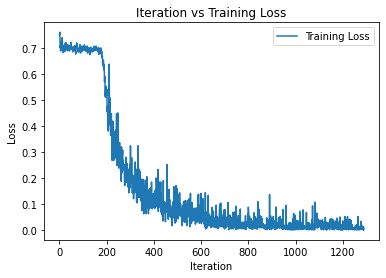

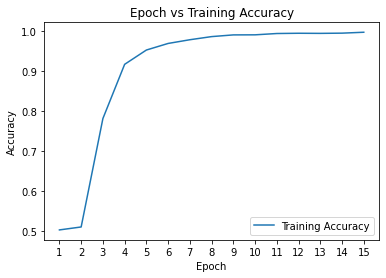

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Iteration vs Training Loss
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")  
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X = np.arange(len(train_accuracies))+1
plt.plot(acc_X, train_accuracies,"-", label="Training Accuracy")
plt.xticks(acc_X)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")  
plt.legend()
plt.show()

## 5. Testing

Test the model.

In [15]:
# Testing
from torch.utils.data import DataLoader

# Load the best-trained model
model.load_state_dict(torch.load(model_params_path))

# Get test data by DataLoader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Start testing
model.eval()

with torch.no_grad():
    
    correct = 0
    count = 0
    record = list()
    
    pbar = tqdm(test_loader)
    for batch in pbar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        
        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(accuracy)
        })
    
        # record the results
        record.append((int(labels),int(predictions)))
        
    pbar.close()
    
time.sleep(0.3)
print("The final accuracy on the test dataset: %s%%" % round(accuracy*100,4))

100%|██████████| 1000/1000 [00:24<00:00, 41.61it/s, loss=0.000, accuracy=0.943]


The final accuracy on the test dataset: 94.3%


Check the result.

In [16]:
# Convert test record to a pandas DataFrame object
from pandas.core.frame import DataFrame
df_record = DataFrame(record)
df_record.columns = ["Ground Truth","Model Prediction"]

# Concat test texts and test records
df = pd.concat([test_texts, df_record], axis=1)

# Show test result
pd.set_option('display.max_rows', None)
df

,ID,Statement 0,Statement 1,Ground Truth,Model Prediction
0,1175,He loves to stroll at the park with his bed,He loves to stroll at the park with his dog.,0,0
1,452,The inverter was able to power the continent.,The inverter was able to power the house,0,0
2,275,The chef put extra lemons on the pizza.,The chef put extra mushrooms on the pizza.,0,0
3,869,sugar is used to make coffee sour,sugar is used to make coffee sweet,0,0
4,50,There are beautiful flowers here and there in ...,There are beautiful planes here and there in t...,1,1
5,1155,"Once a pipe bursts, call a doctor.","Once a pipe bursts, call a plumber.",0,0
6,1395,Everyone hates paying taxes,Nobody hates paying taxes,1,0
7,967,all whales are small,whales are huge,0,0
8,906,the boat enjoyed rolling in the mud,the pig enjoyed rolling in the mud,0,0
9,1465,Barbies are a fantastic desire for kids,Barbies are the horrible desire for kids,1,1


Display the Confusion Matrix of the result.

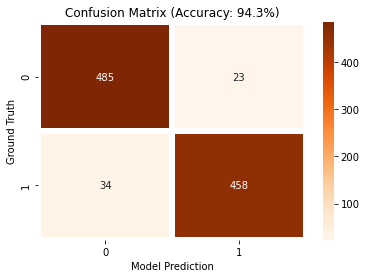

In [17]:
# Display the Confusion Matrix
import seaborn as sns
crosstab = pd.crosstab(df_record["Ground Truth"],df_record["Model Prediction"])
sns.heatmap(crosstab, cmap='Oranges', annot=True, fmt='g', linewidths=5)
accuracy = df_record["Ground Truth"].eq(df_record["Model Prediction"]).sum() / len(df_record["Ground Truth"])
plt.title("Confusion Matrix (Accuracy: %s%%)" % round(accuracy*100,2))
plt.show()

<!-- # Manual Test
check_id = 999

test_data = list(test_loader)
check_target = test_data[check_id]
# print("check_target:",check_target)

input_ids = check_target['input_ids'].to(device)
attention_mask = check_target['attention_mask'].to(device)
labels = check_target['labels']
# print("input_ids:",input_ids)

statements_str = tokenizer.decode(input_ids[0],skip_special_tokens=False)
statements = statements_str.split("[CLS]")[1].split("[SEP]")
print("Task: Which statement of the two is against common sense?")
print("Statement 0:",statements[0])
print("Statement 1:",statements[1])
print()

outputs = model(input_ids, attention_mask=attention_mask)
prediction = predict(outputs)
print("Model Prediction:",int(prediction))
print("Ground Truth:",int(labels)) -->

## Manual Test
Now, let's have a manual test on this trained model.  
First, you need to input two statements that are similar but one is against common sense. Then, our trained model will predict which of the two statements is against common sense. In this way, we can check the performance of the model.  

To perform a manual test, please run the following code block.

In [18]:
manual_test = True
count = 1
while(manual_test):
    print("Let's start our manual test.\n")
    time.sleep(0.3)
    
    statement_1 = input("Please input your first statement (e.g. I drink milk.):\n")
    statement_2 = input("Please input your second statement (e.g. Milk drinks me.):\n")

    # Tokenization for two statements
    inputs = tokenizer(statement_1, statement_2, truncation=True, padding=True, return_tensors="pt").to(device)

    # Model makes its prediction
    outputs = model(**inputs)
    prediction = predict(outputs)

    # Check the performance
    print("\nYour input statememts are:")
    print("Statement 1: ",statement_1)
    print("Statement 2: ",statement_2)
    print("\nThe model thinks the %s statement is against common sense.\n" % ("FIRST" if int(prediction)==0 else "SECOND"))
    
    manual_test = input("Try again? y/n\n")=="y"
    if manual_test:
        count = count + 1
        print("--------------------------------------- %s ---------------------------------------" % count)

Let's start our manual test.

Please input your first statement (e.g. I drink milk.):
I am a student
Please input your second statement (e.g. Milk drinks me.):
I am a program

Your input statememts are:
Statement 1:  I am a student
Statement 2:  I am a program

The model thinks the SECOND statement is against common sense.

Try again? y/n
y
--------------------------------------- 2 ---------------------------------------
Let's start our manual test.

Please input your first statement (e.g. I drink milk.):
I am a student who can fly
Please input your second statement (e.g. Milk drinks me.):
I am a programmer who can program

Your input statememts are:
Statement 1:  I am a student who can fly
Statement 2:  I am a programmer who can program

The model thinks the FIRST statement is against common sense.

Try again? y/n
y
--------------------------------------- 3 ---------------------------------------
Let's start our manual test.

Please input your first statement (e.g. I drink milk.):
I a